In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from collections import Counter


import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [2]:
# Load the full dataset
df = pd.read_csv('olareviews.csv', low_memory=False)

In [3]:
df.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,0.0,f64f8374-6302-42b2-b853-98012d9c6e78,2213mehakjot Kaur9e,https://play-lh.googleusercontent.com/a/AGNmyx...,you have started an option of auto but it is n...,1.0,0.0,5.8.1,3/24/2023 11:04,NaN,NaN
1,1.0,57f7056b-588b-43c2-8278-eed057738c78,Mahesh Mahi,https://play-lh.googleusercontent.com/a-/ACB-R...,Super,5.0,0.0,6.1.5,3/24/2023 11:00,NaN,NaN
2,2.0,cc569be8-6fd8-49be-8689-18e0db1ce2f7,poonam Sharma,https://play-lh.googleusercontent.com/a-/ACB-R...,Good 😊,5.0,0.0,6.1.5,3/24/2023 10:52,NaN,NaN
3,3.0,ef1f9c19-717e-4cd0-a458-ea577ac33489,kids Orignal,https://play-lh.googleusercontent.com/a-/ACB-R...,Bakwas app login is not safe,1.0,0.0,6.1.5,3/24/2023 10:29,NaN,NaN
4,4.0,75d1193d-51ed-4c7b-88fa-4dd951c4f68f,Ankur Garg,https://play-lh.googleusercontent.com/a-/ACB-R...,"Worst app, they charge cancellation fee even w...",1.0,0.0,NaN,3/24/2023 9:48,NaN,NaN


In [4]:
df.shape

(532043, 11)

In [5]:
df.columns

Index(['Unnamed: 0', 'reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt'],
      dtype='object')

In [6]:
# dropping unwanted columns
df.drop(['Unnamed: 0', 'reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt'], axis = 1, inplace = True)

In [7]:
df.head()

,content,score
0,you have started an option of auto but it is n...,1.0
1,Super,5.0
2,Good 😊,5.0
3,Bakwas app login is not safe,1.0
4,"Worst app, they charge cancellation fee even w...",1.0


In [8]:
df.isna().sum()

content    339111
score      339109
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.shape

(192932, 2)

In [11]:
df.head()

,content,score
0,you have started an option of auto but it is n...,1.0
1,Super,5.0
2,Good 😊,5.0
3,Bakwas app login is not safe,1.0
4,"Worst app, they charge cancellation fee even w...",1.0


In [12]:
df.dtypes

content     object
score      float64
dtype: object

In [13]:
df['score'] = df['score'].astype('int')

In [14]:
df.dtypes

content    object
score       int32
dtype: object

In [15]:
df.head()

,content,score
0,you have started an option of auto but it is n...,1
1,Super,5
2,Good 😊,5
3,Bakwas app login is not safe,1
4,"Worst app, they charge cancellation fee even w...",1


In [16]:
def lowercase_text(text):
    return text.lower()

# Apply the lowercase function
df['lowercase_text'] = df['content'].apply(lowercase_text)

In [17]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Apply the remove punctuation function
df['no_punctuation_text'] = df['lowercase_text'].apply(remove_punctuation)

In [18]:
def tokenize_text(text):
    return word_tokenize(text)

# Apply the tokenization function
df['tokenized_text'] = df['no_punctuation_text'].apply(tokenize_text)

In [19]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(words):
    return [word for word in words if word not in stop_words]

# Apply the remove stopwords function
df['no_stopwords_text'] = df['tokenized_text'].apply(remove_stopwords)

In [20]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

# Apply the lemmatization function
df['lemmatized_text'] = df['no_stopwords_text'].apply(lemmatize_words)

In [21]:
# Join the lemmatized words back into a single string
df['cleaned_text'] = df['lemmatized_text'].apply(lambda words: ' '.join(words))

In [22]:
df.head()

,content,score,lowercase_text,no_punctuation_text,tokenized_text,no_stopwords_text,lemmatized_text,cleaned_text
0,you have started an option of auto but it is n...,1,you have started an option of auto but it is n...,you have started an option of auto but it is n...,"[you, have, started, an, option, of, auto, but...","[started, option, auto, available, everytime, ...","[started, option, auto, available, everytime, ...",started option auto available everytime worst ...
1,Super,5,super,super,[super],[super],[super],super
2,Good 😊,5,good 😊,good,[good],[good],[good],good
3,Bakwas app login is not safe,1,bakwas app login is not safe,bakwas app login is not safe,"[bakwas, app, login, is, not, safe]","[bakwas, app, login, safe]","[bakwas, app, login, safe]",bakwas app login safe
4,"Worst app, they charge cancellation fee even w...",1,"worst app, they charge cancellation fee even w...",worst app they charge cancellation fee even wh...,"[worst, app, they, charge, cancellation, fee, ...","[worst, app, charge, cancellation, fee, even, ...","[worst, app, charge, cancellation, fee, even, ...",worst app charge cancellation fee even youre a...


In [23]:
df.iloc[0] ['content']

"you have started an option of auto but it is not available everytime this is worst thing as we book too many rides but I didn't know why are you doing this I will not use ola again and I will go for other apps this is such irritate thing that you started an option of ola but it doesn't available everytime"

In [24]:
df.iloc[0] ['lowercase_text']

"you have started an option of auto but it is not available everytime this is worst thing as we book too many rides but i didn't know why are you doing this i will not use ola again and i will go for other apps this is such irritate thing that you started an option of ola but it doesn't available everytime"

In [25]:
df.iloc[0] ['no_punctuation_text']

'you have started an option of auto but it is not available everytime this is worst thing as we book too many rides but i didnt know why are you doing this i will not use ola again and i will go for other apps this is such irritate thing that you started an option of ola but it doesnt available everytime'

In [26]:
' '.join(df.iloc[0] ['tokenized_text'])

'you have started an option of auto but it is not available everytime this is worst thing as we book too many rides but i didnt know why are you doing this i will not use ola again and i will go for other apps this is such irritate thing that you started an option of ola but it doesnt available everytime'

In [27]:
' '.join(df.iloc[0] ['no_stopwords_text'])

'started option auto available everytime worst thing book many rides didnt know use ola go apps irritate thing started option ola doesnt available everytime'

In [28]:
' '.join(df.iloc[0] ['lemmatized_text'])

'started option auto available everytime worst thing book many ride didnt know use ola go apps irritate thing started option ola doesnt available everytime'

In [29]:
df.iloc[0] ['cleaned_text']

'started option auto available everytime worst thing book many ride didnt know use ola go apps irritate thing started option ola doesnt available everytime'

In [30]:
# Initialize CountVectorizer(Bag of Words)
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['cleaned_text'])

In [31]:
# Sum up the counts of each vocabulary word
word_freq_bow = dict(zip(vectorizer_bow.get_feature_names_out(), np.asarray(X_bow.sum(axis=0)).ravel()))

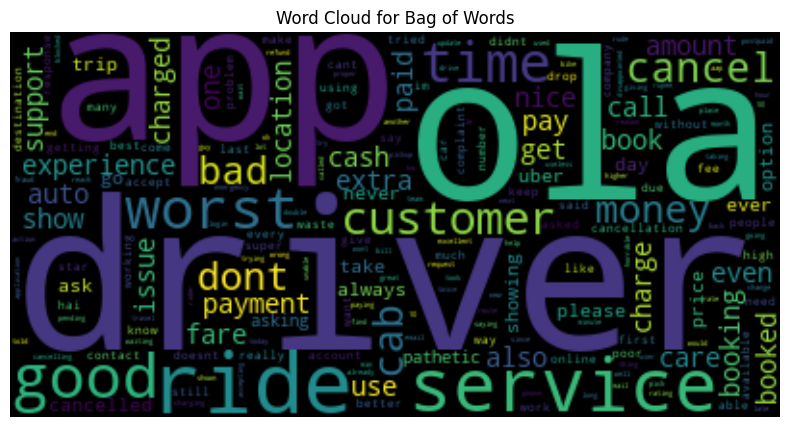

In [32]:
# Generate the word cloud
wordcloud_bow = WordCloud().generate_from_frequencies(word_freq_bow)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bow, interpolation='bilinear')
plt.title('Word Cloud for Bag of Words')
plt.axis('off')
plt.show()

In [33]:
# Initialize TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df['cleaned_text'])

In [34]:
# Sum up the tf-idf scores of each vocabulary word
word_freq_tfidf = dict(zip(vectorizer_tfidf.get_feature_names_out(), np.asarray(X_tfidf.sum(axis=0)).ravel()))

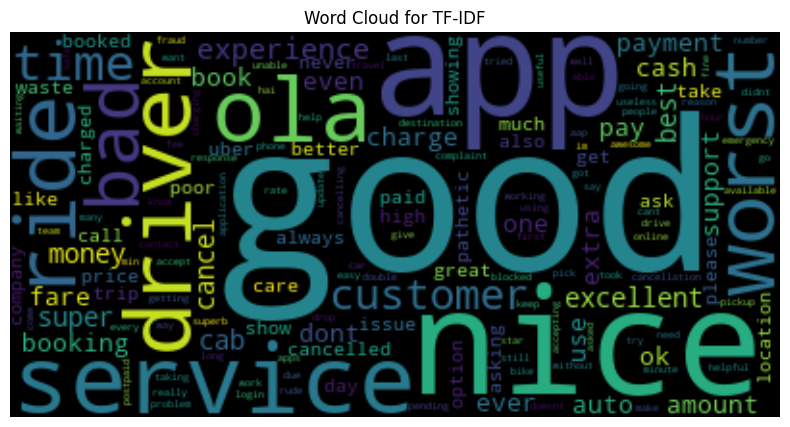

In [35]:
# Generate the word cloud
wordcloud_tfidf = WordCloud().generate_from_frequencies(word_freq_tfidf)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tfidf, interpolation='bilinear')
plt.title('Word Cloud for TF-IDF')
plt.axis('off')
plt.show()

In [36]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['score'], test_size=0.2, random_state=42)
# Initialize and train the model
model_lgbm_tfidf = lgb.LGBMClassifier()
model_lgbm_tfidf.fit(X_train, y_train)

# Make predictions
y_pred_lgbm_tfidf = model_lgbm_tfidf.predict(X_test)

# Evaluate the model
accuracy_lgbm_tfidf = accuracy_score(y_test, y_pred_lgbm_tfidf)

print('TF-IDF Vectorizer using LightGBM')
print('Accuracy:', accuracy_lgbm_tfidf)
print('Classification Report:')
print(classification_report(y_test, y_pred_lgbm_tfidf))
end_time = time.time()
time_lgbm_tfidf = end_time - start_time
print(f"Execution time: {end_time - start_time} seconds")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.918597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220884
[LightGBM] [Info] Number of data points in the train set: 154345, number of used features: 3820
[LightGBM] [Info] Start training from score -0.600937
[LightGBM] [Info] Start training from score -3.217387
[LightGBM] [Info] Start training from score -3.326294
[LightGBM] [Info] Start training from score -2.859564
[LightGBM] [Info] Start training from score -1.144375
TF-IDF Vectorizer using LightGBM
Accuracy: 0.8197579495685076
Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.95      0.91     21229
           2       0.21      0.00      0.01      1493
           3       0.24      0.01      0.02      1393
           4       0.34      0.01      0.03      2329
           5    

In [37]:
start_time = time.time()

X_bow = X_bow.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X_bow, df['score'], test_size=0.2, random_state=42)
# Initialize and train the model
model_lgbm_bow = lgb.LGBMClassifier()
model_lgbm_bow.fit(X_train, y_train)

# Make predictions
y_pred_lgbm_bow = model_lgbm_bow.predict(X_test)

# Evaluate the model
accuracy_lgbm_bow = accuracy_score(y_test, y_pred_lgbm_bow)

print('BOW Vectorizer using LightGBM')
print('Accuracy:', accuracy_lgbm_bow)
print('Classification Report:')
print(classification_report(y_test, y_pred_lgbm_bow))
end_time = time.time()
time_lgbm_bow = end_time - start_time
print(f"Execution time: {end_time - start_time} seconds")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.745654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12185
[LightGBM] [Info] Number of data points in the train set: 154345, number of used features: 3820
[LightGBM] [Info] Start training from score -0.600937
[LightGBM] [Info] Start training from score -3.217387
[LightGBM] [Info] Start training from score -3.326294
[LightGBM] [Info] Start training from score -2.859564
[LightGBM] [Info] Start training from score -1.144375
BOW Vectorizer using LightGBM
Accuracy: 0.8176847124679296
Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.95      0.90     21229
           2       0.11      0.00      0.00      1493
           3       0.28      0.01      0.02      1393
           4       0.30      0.01      0.03      2329
           5       0.75      0.94      0.84     12143

    accuracy                 

In [38]:
start_time = time.time()

# Prepare labels for multi-class classification
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['score'])  # Convert labels to 0-based integers
y_categorical = to_categorical(y_encoded)  # Convert integer labels to one-hot

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_categorical, test_size=0.2, random_state=42)

# Define the model
model_nn_tfidf = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # One output unit per class
])

# Compile the model
model_nn_tfidf.compile(optimizer='adam',
                       loss='categorical_crossentropy',  # Suitable for multi-class classification
                       metrics=['accuracy'])

# Model summary
model_nn_tfidf.summary()


C:\Users\mukul\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │      36,052,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,185,093 (138.04 MB)

 Trainable params: 36,185,093 (138.04 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train the model
history = model_nn_tfidf.fit(X_train, y_train,
                             epochs=10,
                             batch_size=32,
                             validation_data=(X_test, y_test),
                             verbose=1)

Epoch 1/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 825s 171ms/step - accuracy: 0.8112 - loss: 0.6592 - val_accuracy: 0.8281 - val_loss: 0.5927
Epoch 2/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 837s 173ms/step - accuracy: 0.8380 - loss: 0.5543 - val_accuracy: 0.8289 - val_loss: 0.5965
Epoch 3/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 836s 173ms/step - accuracy: 0.8442 - loss: 0.5139 - val_accuracy: 0.8284 - val_loss: 0.6101
Epoch 4/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 837s 174ms/step - accuracy: 0.8551 - loss: 0.4684 - val_accuracy: 0.8262 - val_loss: 0.6411
Epoch 5/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 837s 174ms/step - accuracy: 0.8660 - loss: 0.4348 - val_accuracy: 0.8226 - val_loss: 0.6536
Epoch 6/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 839s 174ms/step - accuracy: 0.8788 - loss: 0.3991 - val_accuracy: 0.8240 - val_loss: 0.7108
Epoch 7/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 839s 174ms/step - accuracy: 0.8885 - loss: 0.3724 - val_accuracy: 0.8206 - val_loss: 0.7450
Epoch 8/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 841s 174ms/step - ac

In [40]:
# Evaluate the model on the test data
loss, accuracy_nn_tfidf = model_nn_tfidf.evaluate(X_test, y_test, verbose=0)
print('TF-IDF Vectorizer using Neural Network')
print('Test Accuracy:', accuracy_nn_tfidf)

# Make predictions (return probabilities)
y_pred_nn_tfidf_prob = model_nn_tfidf.predict(X_test)
y_pred_nn_tfidf = encoder.inverse_transform(y_pred_nn_tfidf_prob.argmax(axis=1))  # Convert probabilities to labels

# Convert one-hot encoded test labels back to labels
y_test_labels = encoder.inverse_transform(y_test.argmax(axis=1))

print('Classification Report:')
print(classification_report(y_test_labels, y_pred_nn_tfidf))

end_time = time.time()
time_nn_tfidf = end_time - start_time
print(f"Execution time: {end_time - start_time} seconds")

TF-IDF Vectorizer using Neural Network
Test Accuracy: 0.8214424252510071
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.95      0.91     21229
           2       0.12      0.02      0.03      1493
           3       0.20      0.04      0.07      1393
           4       0.24      0.03      0.05      2329
           5       0.77      0.94      0.85     12143

    accuracy                           0.82     38587
   macro avg       0.44      0.40      0.38     38587
weighted avg       0.75      0.82      0.77     38587

Execution time: 8379.544127464294 seconds


In [41]:
start_time = time.time()

# Prepare labels for multi-class classification
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['score'])  # Convert labels to 0-based integers
y_categorical = to_categorical(y_encoded)  # Convert integer labels to one-hot

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_bow, y_categorical, test_size=0.2, random_state=42)

# Define the model
model_nn_bow = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # One output unit per class
])

# Compile the model
model_nn_bow.compile(optimizer='adam',
                       loss='categorical_crossentropy',  # Suitable for multi-class classification
                       metrics=['accuracy'])

# Model summary
model_nn_bow.summary()


C:\Users\mukul\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 512)                 │      36,052,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,185,093 (138.04 MB)

 Trainable params: 36,185,093 (138.04 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Train the model
history = model_nn_bow.fit(X_train, y_train,
                             epochs=10,
                             batch_size=32,
                             validation_data=(X_test, y_test),
                             verbose=1)

Epoch 1/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 824s 171ms/step - accuracy: 0.8115 - loss: 0.6675 - val_accuracy: 0.8280 - val_loss: 0.5936
Epoch 2/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 835s 173ms/step - accuracy: 0.8370 - loss: 0.5606 - val_accuracy: 0.8295 - val_loss: 0.5922
Epoch 3/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 837s 173ms/step - accuracy: 0.8461 - loss: 0.5129 - val_accuracy: 0.8292 - val_loss: 0.6178
Epoch 4/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 837s 173ms/step - accuracy: 0.8564 - loss: 0.4701 - val_accuracy: 0.8276 - val_loss: 0.6481
Epoch 5/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 838s 174ms/step - accuracy: 0.8684 - loss: 0.4329 - val_accuracy: 0.8252 - val_loss: 0.6805
Epoch 6/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 838s 174ms/step - accuracy: 0.8764 - loss: 0.4108 - val_accuracy: 0.8259 - val_loss: 0.7090
Epoch 7/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 839s 174ms/step - accuracy: 0.8839 - loss: 0.3910 - val_accuracy: 0.8238 - val_loss: 0.7322
Epoch 8/10
4824/4824 ━━━━━━━━━━━━━━━━━━━━ 839s 174ms/step - ac

In [43]:
# Evaluate the model on the test data
loss, accuracy_nn_bow = model_nn_bow.evaluate(X_test, y_test, verbose=0)
print('BOW Vectorizer using Neural Network')
print('Test Accuracy:', accuracy_nn_bow)

# Make predictions (return probabilities)
y_pred_nn_bow_prob = model_nn_bow.predict(X_test)
y_pred_nn_bow = encoder.inverse_transform(y_pred_nn_bow_prob.argmax(axis=1))  # Convert probabilities to labels

# Convert one-hot encoded test labels back to labels
y_test_labels = encoder.inverse_transform(y_test.argmax(axis=1))

print('Classification Report:')
print(classification_report(y_test_labels, y_pred_nn_bow))

end_time = time.time()
time_nn_bow = end_time - start_time
print(f"Execution time: {end_time - start_time} seconds")

BOW Vectorizer using Neural Network
Test Accuracy: 0.8219607472419739
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.95      0.91     21229
           2       0.12      0.02      0.03      1493
           3       0.13      0.02      0.04      1393
           4       0.21      0.02      0.04      2329
           5       0.77      0.95      0.85     12143

    accuracy                           0.82     38587
   macro avg       0.42      0.39      0.37     38587
weighted avg       0.75      0.82      0.77     38587

Execution time: 8372.056661367416 seconds


time_nn_bow = 8546.496570825577
time_nn_tfidf = 8421.422319412231

In [44]:
accuracy_df = pd.DataFrame({
    'Algorithm': ['Lightgbm', 'Feed-Forward Neural Network', 'Lightgbm', 'Feed-Forward Neural Network'],
    'Vectorizer': ['BoW', 'BoW', 'TF-IDF', 'TF-IDF'],
    'Accuracy': [accuracy_lgbm_bow, accuracy_nn_bow, accuracy_lgbm_tfidf, accuracy_nn_tfidf],
    'Time': [time_lgbm_bow, time_nn_bow, time_lgbm_tfidf, time_nn_tfidf]
})

In [45]:
accuracy_df

,Algorithm,Vectorizer,Accuracy,Time
0,Lightgbm,BoW,0.817685,7.862971
1,Feed-Forward Neural Network,BoW,0.821961,8372.056661
2,Lightgbm,TF-IDF,0.819758,29.115142
3,Feed-Forward Neural Network,TF-IDF,0.821442,8379.544127


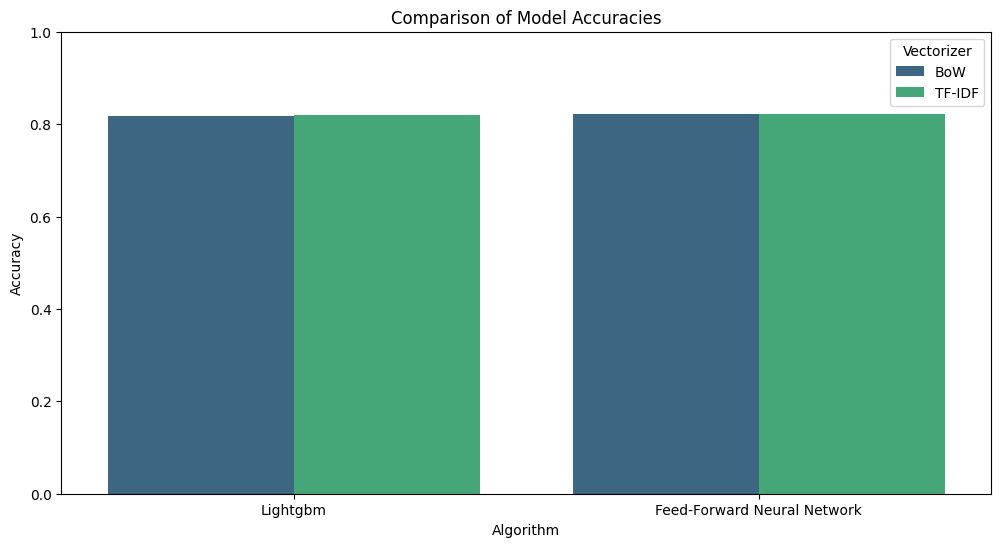

In [46]:
# Create the grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Algorithm', y='Accuracy', hue='Vectorizer', data=accuracy_df, palette='viridis')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.legend(title='Vectorizer')
plt.show()

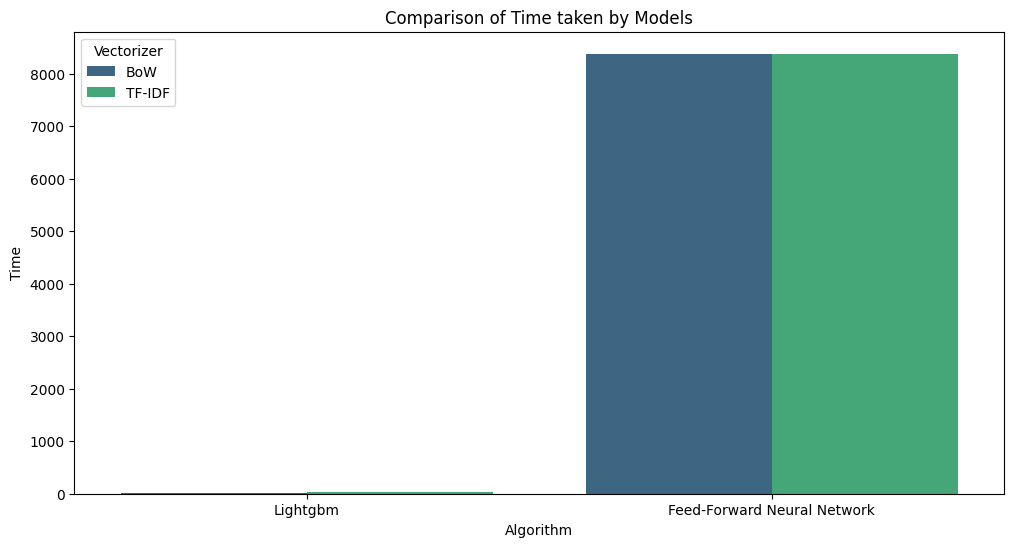

In [47]:
# Create the grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Algorithm', y='Time', hue='Vectorizer', data=accuracy_df, palette='viridis')
plt.title('Comparison of Time taken by Models')
#plt.ylim(0, 1)
plt.xlabel('Algorithm')
plt.ylabel('Time')
plt.legend(title='Vectorizer')
plt.show()